In [1]:
import sys
sys.path


['',
 '/opt/ros/kinetic/lib/python2.7/dist-packages',
 '/home/yang/venv/lib/python35.zip',
 '/home/yang/venv/lib/python3.5',
 '/home/yang/venv/lib/python3.5/plat-x86_64-linux-gnu',
 '/home/yang/venv/lib/python3.5/lib-dynload',
 '/usr/lib/python3.5',
 '/usr/lib/python3.5/plat-x86_64-linux-gnu',
 '/home/yang/venv/lib/python3.5/site-packages',
 '/home/yang/venv/lib/python3.5/site-packages/pykalman-0.9.5-py3.5.egg',
 '/home/yang/.local/lib/python3.5/site-packages',
 '/usr/lib/python3.5/site-packages',
 '/usr/local/lib/python3.5/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.5/dist-packages/IPython/extensions',
 '/home/yang/.ipython']

In [2]:
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

In [3]:
import osmnx as ox
import pandas as pd
import numpy as np
import folium
import networkx as nx
import shapely as sl
import cv2
from matplotlib import pyplot as plt
from pykalman import KalmanFilter
from IPython.display import Image


%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.10'

In [5]:
trajectory = pd.read_csv('match3.csv')
trajectory = trajectory.sort_values('time')
lat = trajectory['latitude']
lon = trajectory['longitude']
margin_lat = (max(lat) - lat.mean()) / 8
margin_lon = (max(lon) - lon.mean()) / 8

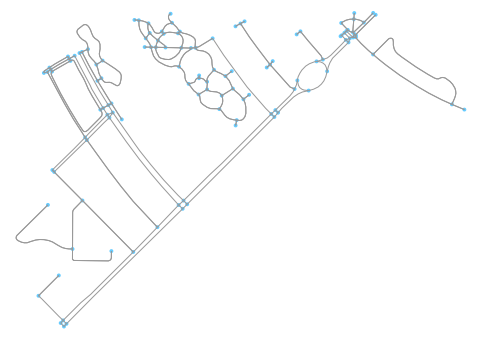

(<Figure size 719.453x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9369061550>)

In [18]:
qwe = ox.graph_from_point((30.8831674687486, 121.92379071795305), distance=1000)
ox.plot_graph(qwe)

In [6]:
# create network from that bounding box
G = ox.core.graph_from_bbox(max(lat) + margin_lat, min(lat) - margin_lat, max(lon) + margin_lon, min(lon) - margin_lon, network_type='drive_service')


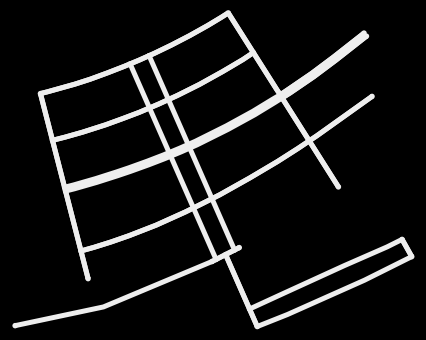

In [7]:
fig, ax = ox.plot_graph(G, bgcolor='k', node_size=30, node_color='#eeeeee', node_edgecolor='none', node_zorder=2,
                        edge_color='#eeeeee', edge_linewidth=5, edge_alpha=1)#, fig_height=300)

In [8]:
X = lat.to_list()
Y = lon.to_list()
n = ox.get_nearest_nodes(G, X, Y)

In [9]:
G_node = G.nodes()
trajectory_node = [[lat[i], lon[i]] for i in range(len(X))]
len(trajectory_node)

11143

In [14]:
route = []
i = 0
interval = 400
while( i < len(trajectory_node) - interval):
    orig = trajectory_node[i]
    dest = trajectory_node[i + interval]
    from_point = ox.get_nearest_node(G, orig)
    end_point = ox.get_nearest_node(G, dest)
    route.append(nx.shortest_path(G, from_point, end_point, weight='length'))
    i += interval
route 

[[2804000117],
 [2804000117],
 [2804000117],
 [2804000117],
 [2804000117],
 [2804000117],
 [2804000117, 2803835877],
 [2803835877, 2804000117, 2804000123, 2803947224, 2803947223],
 [2803947223],
 [2803947223, 2803947224, 2803947225, 2803947226, 2803947228],
 [2803947228, 2803947226, 2804000125, 2804000130, 2803980897],
 [2803980897],
 [2803980897],
 [2803980897, 2804000130, 2804000132],
 [2804000132],
 [2804000132],
 [2804000132, 2804000130, 2803912403, 2803224606],
 [2803224606, 2803912403, 2803912404],
 [2803912404, 2803947235],
 [2803947235],
 [2803947235],
 [2803947235, 2803947233],
 [2803947233, 2803835880],
 [2803835880, 2803988001, 2803835882],
 [2803835882],
 [2803835882],
 [2803835882, 2803947239, 2803947241]]

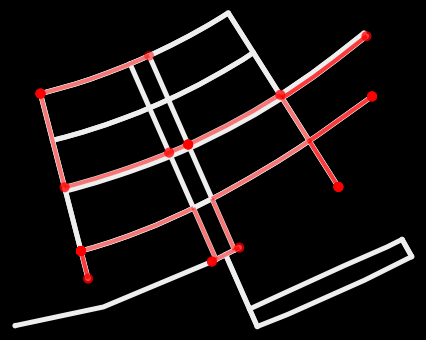

In [15]:
fig, ax = ox.plot_graph_routes(G, route, bgcolor='k', node_size=30, node_color='#eeeeee', node_edgecolor='none', node_zorder=2,
                        edge_color='#eeeeee', edge_linewidth=5, edge_alpha=1)


In [127]:
import math
# import matplotlib as plt

def img_rotate(fig, steer, path):
    '''
    Input:
        fig: the osmnx output map figure in type of matplotlib.figure.Figure
        steer: the car steer angle in rad
        path: the path to save the rotated image
    Output:
        Save the iamge file to the path
    '''
    
    assert type(path) == str
    fig.set_size_inches(3, 3)
    fig.canvas.draw()
    img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    img = img.reshape(fig.canvas.get_width_height()[::-1]+ (3,))
    rows,cols = img.shape[0],img.shape[1]
#     angle = steer / 2*math.pi * 360
    angle = steer

    print(angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,2)
    dst = cv2.warpAffine(img,M,(cols,rows))
#     plt.figure(figsize = (6,6))
#     plt.imshow(dst)
#     plt.axis("off")
#     plt.show()
    cv2.imwrite(path+".png", dst)
    print(path+".png saved")

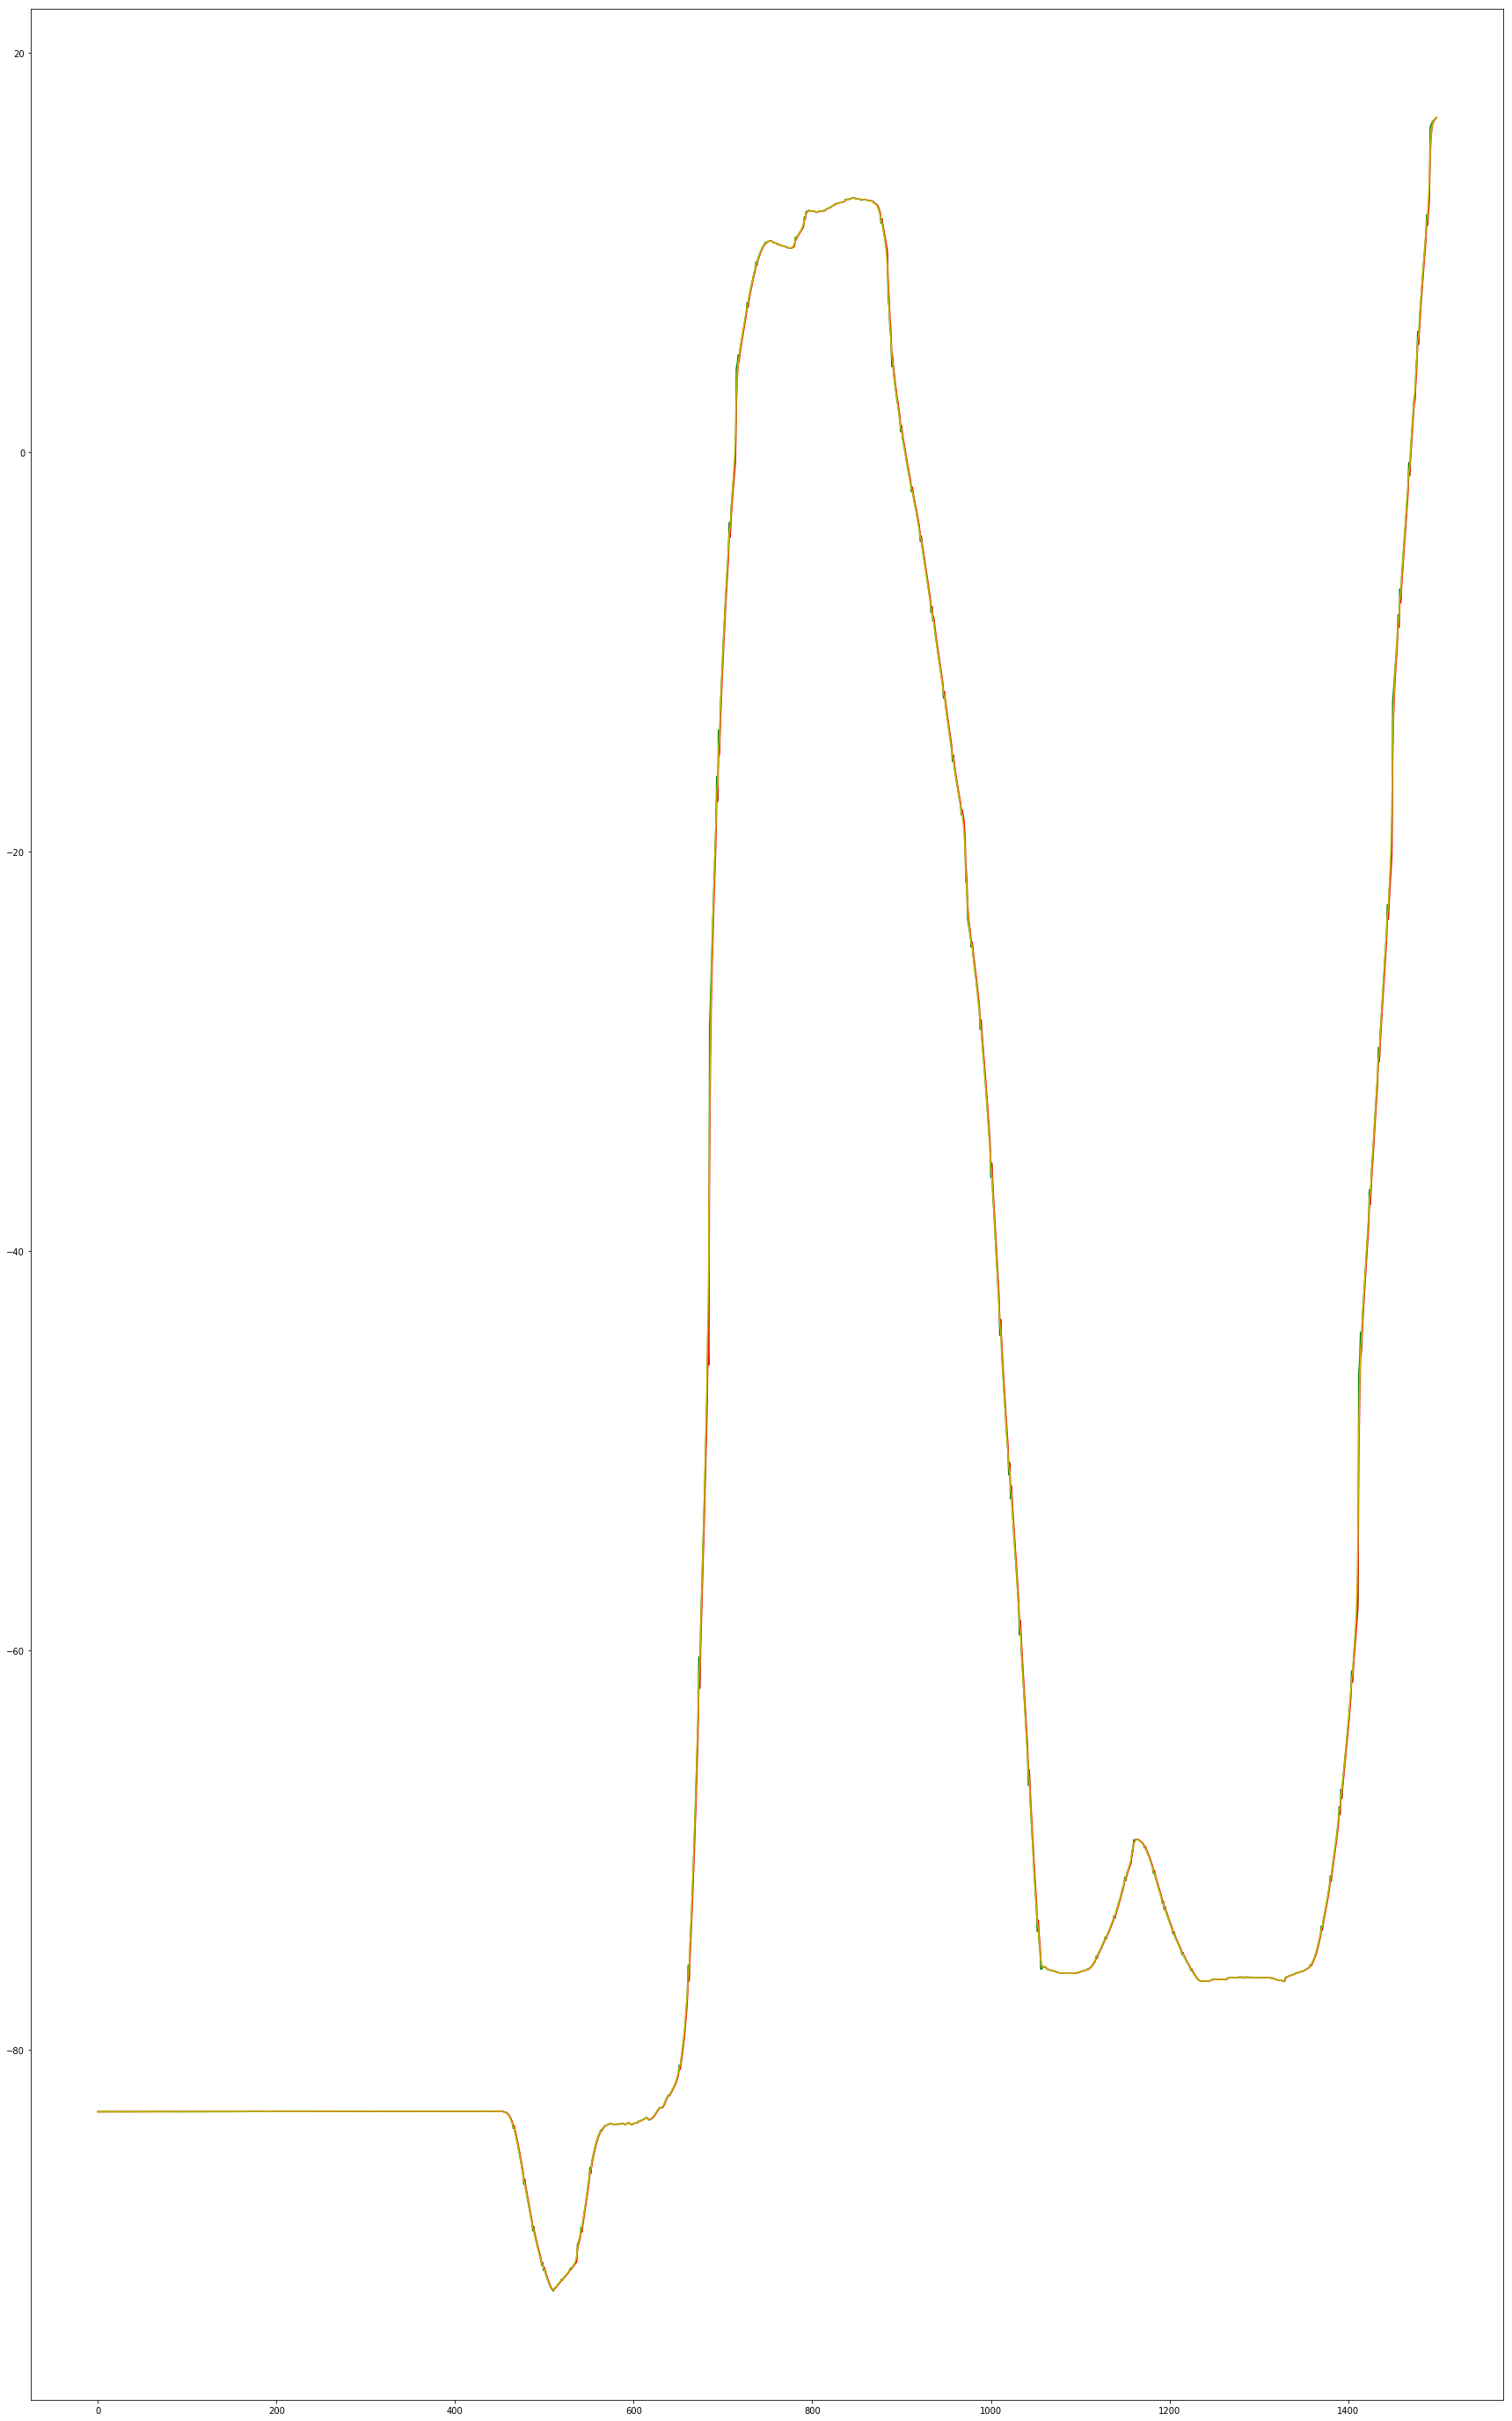

In [126]:
rtk_data = trajectory['new_heading'].values
rtk_data = 360 * rtk_data / (2 * math.pi)
kf = KalmanFilter(n_dim_obs = 1,
                  n_dim_state = 1,
                  initial_state_mean = 1,
                  initial_state_covariance = 1,
                  transition_matrices = [1],
                  transition_covariance = np.eye(1),
                  transition_offsets = None,
                  observation_matrices = [1],
                  observation_covariance = 1
                 )

rtk_mean,cov = kf.filter(rtk_data)
rtk_mean_sm,cov_sm = kf.smooth(rtk_data)
plt.figure(figsize=(30,50))
# plt.ylim()
plt.plot(rtk_data[1500:3000],'g-')
plt.plot(rtk_mean[1500:3000], 'r-')
plt.plot(rtk_mean_sm[1500:3000], 'y-')

plt.show()
 

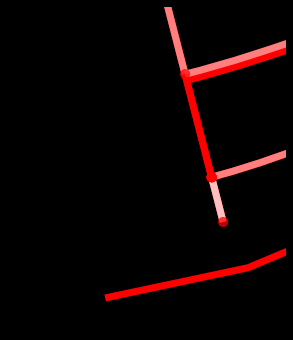

[156.89297503]
routed_map_0723/15638734704.png saved


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [98]:
i = 1600
zoom_lat = 4
zoom_lon = 4
margin_lat = margin_lon = 0.0005
fig, ax = ox.plot_graph_routes(G, route, bbox = (lat.reset_index().iloc[i][1]+margin_lat*zoom_lat, lat.reset_index().iloc[i][1]-margin_lat*zoom_lat, lon.reset_index().iloc[i][1]+margin_lon*zoom_lon, lon.reset_index().iloc[i][1]-margin_lon*zoom_lon), bgcolor='k', node_alpha=0, node_color='b', node_edgecolor='none', node_zorder=2,
                edge_color='r', edge_linewidth=7, edge_alpha=1, route_linewidth=7, route_color='w')
img_rotate(fig, rtk_mean_sm[i], 'routed_map_0723/%d'%(trajectory['time'].iloc[i]))


In [ ]:
zoom_lat = 2
zoom_lon = 4
margin_lat = margin_lon = 0.0005
for i in range (len(lat)):
    print('**********************************')
    fig, ax = ox.plot_graph_routes(G, route, bbox = (lat.reset_index().iloc[i][1]+margin_lat*zoom_lat+0.0020, lat.reset_index().iloc[i][1]-margin_lat*zoom_lat+0.0002, lon.reset_index().iloc[i][1]+margin_lon*zoom_lon, lon.reset_index().iloc[i][1]-margin_lon*zoom_lon), bgcolor='k', node_alpha=0, node_color='b', node_edgecolor='none', node_zorder=2,
                    edge_color='w', edge_linewidth=7, edge_alpha=1, route_linewidth=7, route_color='w')
    img_rotate(fig, rtk_mean_sm[i], 'unrouted_map_0723/%d'%(trajectory['time'].iloc[i]))

    
#     fig.savefig('origin_map/%d.jpg'%(trajectory.iloc[i][2]))

In [128]:
map = folium.Map(
    location = [lat.mean(), lon.mean()],
    zoom_start = 16
)
map.add_child(folium.LatLngPopup())